In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


In [504]:
df = pd.read_csv('./data/WineQT.csv')
df.set_index('Id')
y_raw = df['quality']


In [505]:
class TierColumnAdder:

    def __init__(self, tier_col_name='quality'):
        self.tier_col_name = tier_col_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        series = X[self.tier_col_name]
        self.avg_qual = series.mean()
        self.top_tier = series.quantile(.95)
        self.bottom_tier = series.quantile(.01)
        self.min = series.min()
        self.max = series.max()
        above_avg = X[self.tier_col_name] >= self.avg_qual
        top = X[self.tier_col_name] >= self.top_tier
        bot = X[self.tier_col_name] <= self.bottom_tier
        min = X[self.tier_col_name] == self.min
        max = X[self.tier_col_name] == self.max
        return X.assign(above_avg=above_avg, top_tier=top, bottom_tier=bot, worst=min, best=max)

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X)
        return self.transform(X)


In [506]:
class OneScaler:

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.centered = X - X.mean()
        self.v_min = self.centered.min().abs()
        self.v_max = self.centered.max()
        self.above_mean = self.centered >= 0
        self.scaled_high = self.centered[self.above_mean] / self.v_max
        self.scaled_low = self.centered[~self.above_mean] / self.v_min
        self.combined = self.scaled_high.fillna(self.scaled_low)
        return self.combined

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)


In [507]:
class ColumnSelector:

    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.col_names]

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)

In [508]:
class MulticlassEvaluator:

    def __init__(self, pipeline):
        self.pipeline = pipeline

    def fit(self, X, y=None):
        self.pipeline.fit(X, y)
        return self

    def transform(self, X):
        return self.pipeline.transform(X)

    def fit_transform(self, X, y=None, **fit_params):
        return self.pipeline.fit_transform(X, y)

    def fit_predict(self, X, y=None):
        return self.pipeline.fit_predict(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def evaluate(self, X, y, cv=3, labels=None, scoring='accuracy'):
        y_pred = pipeline.predict(X)
        conf_mx = confusion_matrix(y, y_pred, labels=labels)
        plt.matshow(conf_mx, cmap=plt.cm.BrBG_r)
        plt.show()
        print(conf_mx)
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
        print('CV Scores - ', scores)

    def train_test_evaluate(self, X, y, test_size=0.2, random_state=None):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        self.fit(X_train, y_train)
        self.evaluate(X_train, y_train)
        self.evaluate(X_test, y_test)


In [509]:
columns = ['alcohol', 'sulphates', 'citric acid', 'fixed acidity', 'chlorides', 'density',
           'total sulfur dioxide', 'volatile acidity', 'above_avg', 'top_tier', 'bottom_tier', 'best', 'worst']


In [510]:
pipeline = Pipeline([('col_adder', TierColumnAdder()), ('selector', ColumnSelector(
    columns)), ('scaler', OneScaler()), ('poly', PolynomialFeatures(degree=2, include_bias=True)), ('estimator', RandomForestClassifier(random_state=42))])


In [511]:
evaluator = MulticlassEvaluator(pipeline)

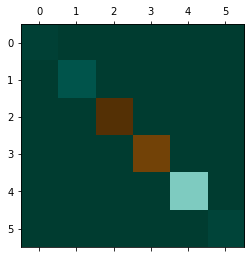

[[  6   0   0   0   0   0]
 [  0  24   0   0   0   0]
 [  0   0 390   0   0   0]
 [  0   0   0 368   0   0]
 [  0   0   0   0 117   0]
 [  0   0   0   0   0   9]]
CV Scores -  [1. 1. 1.]


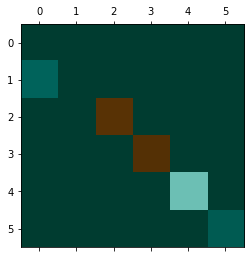

[[ 0  0  0  0  0  0]
 [ 9  0  0  0  0  0]
 [ 0  0 93  0  0  0]
 [ 0  0  0 94  0  0]
 [ 0  0  0  0 26  0]
 [ 0  0  0  0  0  7]]
CV Scores -  [1. 1. 1.]


In [512]:
evaluator.train_test_evaluate(df, y_raw, test_size=0.2)